In [56]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data_SbleTgt_WRMSE import get_config as get_config
#from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data_WRMSE import get_config as get_config
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data_StbleTgt_WRMSE import get_config as get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [58]:
config = get_config()
print(config.beta_min)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = 1 / config.ts_length

0.0
Using CPU



In [59]:
def get_drift_files(config, ts_type_str):
    ts_type = f"{ts_type_str}"
    if "BiPot" in ts_type_str:
        include =  (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                    ".", "")
    elif "QuadSin" in ts_type_str:
        include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                ".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    driftevalexp_files = []
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_dir):
        if "LSTM" in file and ts_type in file and include in file:
            if "_ST_" in file and "QuadSin" in file:
                print(file)
            if (("ST" in ts_type_str and "_ST_" in file) or (("ST" not in ts_type_str and "_ST_" not in file))):
                if "muhats" in file and "DriftEvalExp" in file:
                    driftevalexp_files.append(root_dir+file)
                elif "OOSDriftTrack" in file and "true" in file:
                    driftoostrack_true_files.append(root_dir+file)
                elif "OOSDriftTrack" in file and "local" in file:
                    driftoostrack_local_files.append(root_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert len(driftevalexp_files)>0, "No eval exp files found"
    def extract_bw_drift_eval_exp_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftevalexp_files = sorted(driftevalexp_files, key=extract_bw_drift_eval_exp_number)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    Nepochs_drifteval = [extract_bw_drift_eval_exp_number(f) for f in driftevalexp_files]
    return driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval

In [60]:
if "BiPot" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ts_type_str = "ST_fBiPot"
    else:
        ts_type_str = "fBiPot"
elif "QuadSinHF" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ts_type_str = "ST_fQuadSinHF"
    else:
        ts_type_str = "fQuadSinHF"
print(ts_type_str)
driftevalexp_files, driftoostrack_true_files, driftoostrack_local_files, Nepochs_track, Nepochs_drifteval = get_drift_files(config=config, ts_type_str=ts_type_str)

ST_fQuadSinHF
TSPM_LSTM_ST_fQuadSinHF_OOSDriftTrack_3946Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_true_states.npy
TSPM_LSTM_ST_fQuadSinHF_OOSDriftTrack_764Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_local_states.npy
TSPM_LSTM_ST_fQuadSinHF_OOSDriftTrack_5004Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_local_states.npy
TSPM_LSTM_ST_fQuadSinHF_OOSDriftTrack_2866Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_local_states.npy
TSPM_LSTM_ST_fQuadSinHF_OOSDriftTrack_162Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_true_states.npy
TSPM_LSTM_ST_fQuadSinHF_OOSDriftTrack_4170Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_local_states.npy
TSPM_LSTM_ST_fQuadSinHF_OOSDriftTrack_3912Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_local_states.npy
TSPM_LSTM_ST_fQuadSinHF_OOSDriftTrack_1066Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_local_states.npy
TSPM_LSTM_ST_fQuadSinHF_DriftEvalExp_1606Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_muhats.npy
TSPM_LSTM_ST_fQuadSinHF_O

In [61]:
driftoostrack_true_files

['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_ST_fQuadSinHF_OOSDriftTrack_2Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_true_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_ST_fQuadSinHF_OOSDriftTrack_4Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_true_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_ST_fQuadSinHF_OOSDriftTrack_6Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_true_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_ST_fQuadSinHF_OOSDriftTrack_8Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_true_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_ST_fQuadSinHF_OOSDriftTrack_10Nep_00t0_3906e-03dT_05a_004b_250c_10ResLay_2LFac_true_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_LSTM_ST_fQuadSinHF_OOSDrif

In [70]:
eval_exp_rmses = {}
for f in zip(*[Nepochs_drifteval, driftevalexp_files]):
    Nepoch = f[0]
    file = f[1]
    try:
        if Nepoch > 18190: raise FileNotFoundError
        muhats = torch.Tensor(np.load(file, allow_pickle=True))
        Xshape = muhats.shape[0]
        Xs = torch.Tensor(np.linspace(-1.5,1.5,Xshape))#np.load(file_path+"numpyXs.npy"))
        if "BiPot" in config.data_path:
            true_drifts = -(4.*config.quartic_coeff * np.power(Xs, 3) + 2.*config.quad_coeff * Xs + config.const).numpy()
        elif "QuadSin" in config.data_path:
            true_drifts = (-2. * config.quad_coeff * Xs + config.sin_coeff * config.sin_space_scale * np.sin(
        config.sin_space_scale * Xs)).numpy()
        mu_hats = muhats[:, -1, :].reshape(muhats.shape[0], muhats.shape[-1]*1).mean(dim=-1).numpy()
        rmse = rmse_ignore_nans(true_drifts, mu_hats).astype(np.float64)
        eval_exp_rmses.update({Nepoch: round(rmse, 4)})
    except pickle.UnpicklingError as e:
        continue
    except [FileNotFoundError] as e:
        continue
Nepochs_drifteval = np.array(list(eval_exp_rmses.keys())).flatten()
eval_exp_rmses

{2: 3.9931,
 4: 1.1751,
 6: 1.0866,
 8: 1.0347,
 10: 0.9477,
 12: 0.8143,
 14: 0.7876,
 16: 0.7739,
 18: 0.7591,
 20: 0.7495,
 22: 0.7437,
 24: 0.7306,
 26: 0.7387,
 28: 0.7283,
 30: 0.7242,
 32: 0.7244,
 34: 0.7276,
 36: 0.7239,
 38: 0.7226,
 40: 0.719,
 42: 0.7198,
 44: 0.7185,
 46: 0.7167,
 48: 0.7178,
 50: 0.7162,
 52: 0.7162,
 54: 0.717,
 56: 0.7163,
 58: 0.7178,
 62: 0.7159,
 64: 0.7167,
 66: 0.7144,
 68: 0.7419,
 70: 0.7153,
 72: 0.7125,
 74: 0.7144,
 76: 0.7126,
 78: 0.7191,
 80: 0.7171,
 82: 0.7125,
 84: 0.7195,
 86: 0.7121,
 88: 0.7116,
 90: 0.7312,
 92: 0.7117,
 94: 0.7108,
 96: 0.7147,
 98: 0.7111,
 102: 0.7107,
 104: 0.711,
 106: 0.7327,
 108: 0.7102,
 110: 0.7135,
 112: 0.7117,
 114: 0.7321,
 116: 0.7125,
 118: 0.7375,
 120: 0.7151,
 122: 0.7193,
 124: 0.7123,
 126: 0.7141,
 128: 0.7362,
 130: 0.761,
 132: 0.7114,
 134: 0.7108,
 136: 0.7126,
 138: 0.7164,
 140: 0.7088,
 142: 0.7083,
 144: 0.7354,
 146: 0.7422,
 148: 0.7279,
 152: 0.7224,
 154: 0.73,
 156: 0.8127,
 158: 0.

In [71]:
drift_track_rmses = {}
for f in zip(*[Nepochs_track, driftoostrack_true_files, driftoostrack_local_files]):
    Nepoch = f[0]
    true = f[1]
    local = f[2]
    try:
        all_true_states = np.load(true, allow_pickle=True)/np.sqrt(config.deltaT)
        all_local_states= np.load(local,allow_pickle=True)/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
    except pickle.UnpicklingError as e:
        continue
    except FileNotFoundError as e:
        print(e)
        continue
Nepochs_track= np.array(list(drift_track_rmses.keys())).flatten()
drift_track_rmses

{2: 0.24252758259705046,
 4: 0.05461731675370106,
 6: 0.04943218844967047,
 8: 0.04857966148993194,
 10: 0.046989568031631,
 12: 0.04518159475672927,
 14: 0.045044181019609095,
 16: 0.04506943675271959,
 18: 0.04471712690318098,
 20: 0.04474043787395644,
 22: 0.04488169435369264,
 24: 0.0442605160580822,
 26: 0.04497445703139409,
 28: 0.0442549704699075,
 30: 0.04420711072821511,
 32: 0.04401908034705547,
 34: 0.044124827135191266,
 36: 0.04413894331807863,
 38: 0.04437067866068328,
 40: 0.043981111185326834,
 42: 0.04432828670576881,
 44: 0.04403175541963432,
 46: 0.04403389154736489,
 48: 0.04411579307047791,
 50: 0.04402027664153409,
 52: 0.043965698005729206,
 54: 0.04396828903548239,
 56: 0.04399367955545287,
 58: 0.04397349939152232,
 62: 0.04416569211364761,
 64: 0.04398639176005388,
 66: 0.04406423667656281,
 68: 0.04525595230451995,
 70: 0.0438749904326784,
 72: 0.04385940860043764,
 74: 0.04385039280903255,
 76: 0.043855933915857195,
 78: 0.04445673383686648,
 80: 0.043953854

In [72]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.sqrt(np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])

In [73]:
common_epochs = np.intersect1d(np.intersect1d(Nepochs_losses, Nepochs_drifteval), Nepochs_track)#np.intersect1d(Nepochs_losses, Nepochs_drifteval)
#common_epochs = common_epochs[np.array([(10<=c<=960) for c in common_epochs])]
start_idx = 1
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
evalexp_idx = [np.argwhere(c == Nepochs_drifteval)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
eval_rmses = np.array(list(eval_exp_rmses.values()))[evalexp_idx]
track_idx = [np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs]
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]

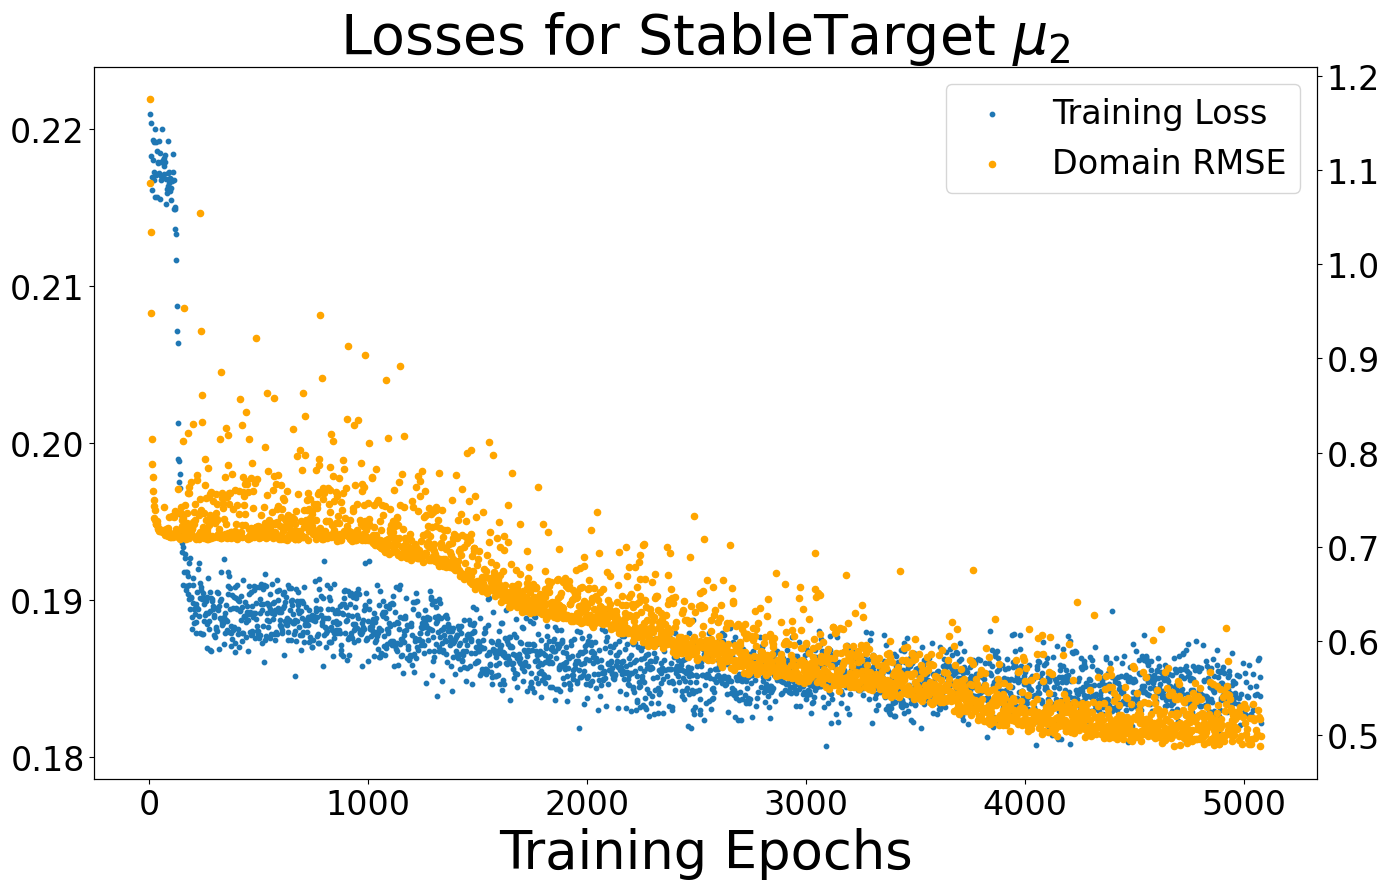

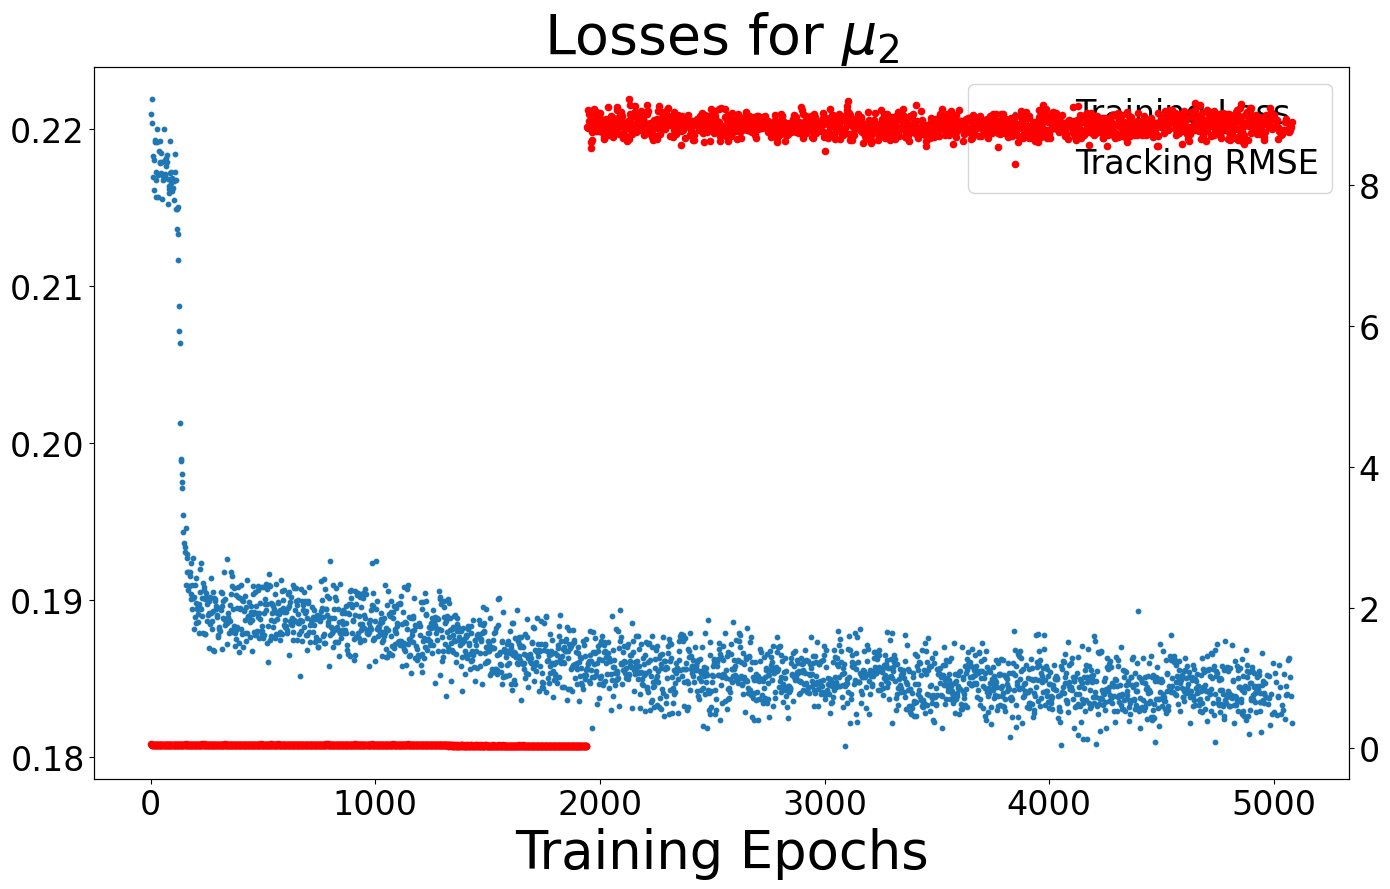

In [74]:
toSave = False
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax.tick_params(axis="both",labelsize=24)
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, eval_rmses, s=20, color="orange",label="Domain RMSE")
ax.set_xlabel("Training Epochs", fontsize=38)
if "BiPot" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ax.set_title(r"Losses for StableTarget $\mu_{3}$", fontsize=40)
    else:
        ax.set_title(r"Losses for $\mu_{3}$", fontsize=40)
elif "QuadSinHF" in config.data_path:
    if "004b" in config.data_path:
        if "_ST_" in config.scoreNet_trained_path:
            ax.set_title(r"Losses for StableTarget $\mu_{2}$", fontsize=40)
        else:
            ax.set_title(r"Losses for $\mu_{2}$", fontsize=40)
    else:
        if "_ST_" in config.scoreNet_trained_path:
            ax.set_title(r"Losses for StableTarget $\mu_{1}$", fontsize=40)
        else:
            ax.set_title(r"Losses for $\mu_{1}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    if "BiPot" in config.data_path:
        if "_ST_" in config.scoreNet_trained_path:
            plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}_ST_LossesEval_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
        else:
            plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}_LossesEval_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
    elif "QuadSinHF" in config.data_path:
        if "004b" in config.data_path:
            if "_ST_" in config.scoreNet_trained_path:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}2_ST_LossesEval_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
            else:
                 plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}2_LossesEval_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
        else:
            if "_ST_" in config.scoreNet_trained_path:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}1_ST_LossesEval_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
            else:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}1_LossesEval_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking RMSE")
ax.set_xlabel("Training Epochs", fontsize=38)
if "BiPot" in config.data_path:
    if "_ST_" in config.scoreNet_trained_path:
        ax.set_title(r"Losses for StableTarget $\mu_{3}$", fontsize=40)
    else:
        ax.set_title(r"Losses for $\mu_{3}$", fontsize=40)
elif "QuadSinHF" in config.data_path:
    if "004b" in config.data_path:
        ax.set_title(r"Losses for $\mu_{2}$", fontsize=40)
    else:
        ax.set_title(r"Losses for $\mu_{1}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    if "BiPot" in config.data_path:
        if "_ST_" in config.scoreNet_trained_path:
            plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}_ST_LossesTrack_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
        else:
            plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}_LossesTrack_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
    elif "QuadSinHF" in config.data_path:
        if "004b" in config.data_path:
            if "_ST_" in config.scoreNet_trained_path:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}2_ST_LossesTrack_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
            else:
                 plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}2_LossesTrack_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
        else:
            if "_ST_" in config.scoreNet_trained_path:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}1_ST_LossesTrack_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
            else:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/{ts_type_str}1_LossesTrack_PM_LSTM_{config.deltaT:.3e}dT_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
df = pd.DataFrame([eval_rmses, track_rmses], columns=common_epochs, index=["DomainRMSE", "TrackRMSE"])
df.T.describe()

In [ ]:
raise RuntimeError

In [ ]:
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data_SbleTgt import get_config as get_config
gconfig2 = get_config()
with open(gconfig2.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        print(f)
        losses2 = np.array(pickle.load(f))[:losses.shape[0]]
plt.scatter(np.arange(start_idx, losses2.shape[0]), losses2[start_idx:],s=2, label="Stable Target")
#plt.hlines(np.sqrt(config.deltaT), xmin = start_idx, xmax=losses.shape[0]-start_idx, color="red")
plt.yscale("log")
plt.legend()
losses2[-1]/losses2[start_idx]

In [ ]:
start_idx = 00
def compute_ema(loss_tensor, beta):
    ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
    ema_values[0] = loss_tensor[0]  # First value stays the same

    for i in range(1, len(loss_tensor)):
        ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

    return ema_values
# Define EMA decay rates
beta_short = 0.9   # Short-term trend (reacts quickly)
beta_long = 0.99   # Long-term trend (smoother)

# Compute EMAs
short_term_ema = compute_ema(losses, beta_short)
long_term_ema = compute_ema(losses, beta_long)
plt.scatter(np.arange(start_idx, short_term_ema.shape[0]), (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
plt.yscale("log")
plt.legend()
plt.show()
plt.scatter(np.arange(start_idx, long_term_ema.shape[0]), (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
plt.yscale("log")
plt.legend()
plt.show()